# `peak_matching_fn.ipynb`
The goal of this file is to implement the method used in `peak_matching.ipynb` for the FN model. If it works, it should be added to `peak_matching.py`.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numba import jit
from color import *
import mutual_information as mtin
from WSN import *
from tqdm import tqdm

In [2]:
if mtin.default_fn_sol is None:
    mtin.default_fn_equ_params["T"] = 20_000
    mtin.default_fn_equ_params["dt"] = 0.01
    mtin.default_fn_sol = np.load("default_fn_sol_dt_0.01.npy")

In [3]:
@jit(nopython=True)
def dist2(r1: np.ndarray, r2: np.ndarray):
    diff = r1 - r2
    return np.dot(diff, diff)

@jit(nopython=True)
def dist(r1: np.ndarray, r2: np.ndarray):
    return np.sqrt(dist2(r1, r2))

In [4]:
@jit(nopython=True)
def get_points_frames(nodes: np.ndarray, times: np.ndarray, points: np.ndarray, frames: int, wavelength: float, period: float, epsilon: float):
    points_frames = np.empty((frames, *points.shape))
    combinatory_dxs = np.empty((frames, len(points)))
    for frame in range(frames):
        for p, point in enumerate(points):
            dx = np.zeros(2)
            combinatory_dx = 0.0
            for node, t in zip(nodes, times):
                d = dist(point, node)
                rhat = (node - point) / d
                dx_mag = np.sin(2 * np.pi * (d / wavelength - t / period))
                dx += rhat * dx_mag
                combinatory_dx += np.abs(dx_mag)
            point += epsilon * dx
            combinatory_dxs[frame, p] = epsilon * combinatory_dx
        points_frames[frame] = points
    return points_frames, combinatory_dxs

In [5]:
N = 6
c = 1.6424885622140555
wsn = WSN(100, N, std=0, D=142, c=c)
bb = wsn.reset_nodes_bounding_box()
wsn.reset_anchors(N)
wsn.nodes = wsn.nodes.astype(np.int32)


6


In [6]:
wsn.nodes

array([[54,  7],
       [65, 52],
       [74, 35],
       [47, 48],
       [74,  4],
       [43, 33]])

In [7]:
mtin.get_fn_data(1000, wsn.nodes, start_frame=4000).shape

(6, 16001, 2)

In [8]:
xs = np.arange(0, 100, 1.0)
ys = np.arange(0, 100, 1.0)
xs, ys = points = np.array(np.meshgrid(xs, ys)).reshape((2, -1))
points = points.T
r0 = np.array([55, 55])

In [9]:
results = wsn.transmit_continuous(signal_type="fn", start_frame=4000)
all_peaks, period = mtin.get_fn_peaks_inside_period(results, c)
wavelength = period * c
times = np.concatenate(([0], all_peaks[:, 1]))

d:\Repositories\WSN-Localization\mutual_information.py:105: RuntimeWarning: divide by zero encountered in log
  mi = -0.5 * np.log(np.linalg.det(cor))


In [10]:
times

array([ 0.  , -3.81, -3.29, -2.66, -3.6 ,  0.08])

In [11]:
dx_errs = []
est_poss = []
for ph0 in tqdm(np.arange(0, 1, 0.01)):
    points_frames, combinatory_dxs = get_points_frames(wsn.nodes, times + ph0 * period, points, 300, wavelength=wavelength, period=period, epsilon=0.1)
    argmin = np.nanargmin(combinatory_dxs[-1])
    est_pos = points_frames[-1, argmin]
    dx_errs.append(combinatory_dxs[-1, argmin])
    est_poss.append(est_pos)
dx_errs = np.array(dx_errs)
est_poss = np.array(est_poss)


100%|██████████| 100/100 [15:59<00:00,  9.60s/it]


In [12]:
def plot_points_frame(points_frame, combinatory_dxs):
    mincd = np.nanmin(combinatory_dxs)
    maxcd = np.nanmax(combinatory_dxs)
    plt.scatter(
        points_frame[:, 0], points_frame[:, 1], s=1, 
        c=[
            interpolate_color("#1010ee", "#d4d4d4", (cd - mincd) / (maxcd - mincd)).get_hex()
            if not np.isnan(cd) else "#d4d4d4"
            for cd in combinatory_dxs
        ]
    )
    plt.scatter(
        *points_frame[np.nanargmin(combinatory_dxs)], marker='x', c="red"
    )

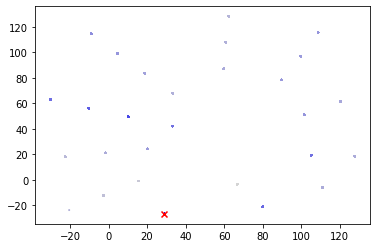

In [13]:
plot_points_frame(points_frames[-1], combinatory_dxs[-1])

In [14]:
argmin = np.argmin(dx_errs)
r0, est_poss[argmin], dx_errs[argmin]

(array([55, 55]), array([ 36.2242939 , -15.46361821]), 0.06443255315533705)

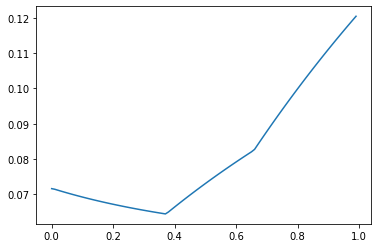

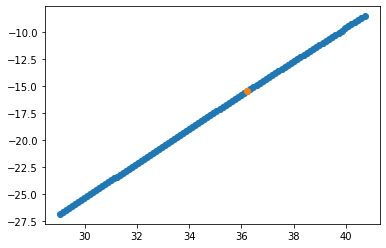

In [16]:
plt.plot(np.arange(0, 1, 0.01), dx_errs)
plt.show()
plt.scatter(est_poss[:, 0], est_poss[:, 1])
plt.scatter(*est_poss[np.argmin(dx_errs)])
plt.show()